In [3]:
import numpy as np
import os
import matplotlib as mpl
import matplotlib.pyplot as plt
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.datasets import mnist

# Federated convex optimization: Experimenting with multiclass logistic regression on the MNIST dataset

This notebook runs an experiment with two federated convex optimization approaches, used to fit a multiclass logistic regression model on the MNIST dataset.

### Notebook outline:
* Importing MNIST and implementing multiclass logistic regression
* Tuning inner/outer step sizes method
    - K=5, R=100, M=5/50
    - K=25, R=40, M=5/50
    - K=100, R=10, M=5/50
* Tuning modified DSVRG method
    - K=5, R=100, M=5/50
    - K=25, R=40, M=5/50
    - K=100, R=10, M=5/50
* Comparison of results

### Experimental design
* Import 60_000 MNIST training examples and shuffle the order
* Objective function: $F(w) = \sum_{i = 1}^{60,000} f_i(w)$ where $f_i(w) = -\log P(y_i\mid x_i ; w)$ and $P(y_i \mid x_i ; w)$ is a softmax score of the predicted value in a 10-class logistic regression.
* We attempt to minimize $F(w)$ using at most one gradient accesses to each $f_i$.

In [4]:
# Import the MNIST dataset
current_dir = os.getcwd()
(X_train, Y_train), (X_test, Y_test) = mnist.load_data(path=current_dir+'/mnist.npz')

In [5]:
# Shuffle training data order
p = np.random.permutation(X_train.shape[0])
X_train = X_train[p]
Y_train = Y_train[p]

In [6]:
X_train.shape, Y_train.shape

((60000, 28, 28), (60000,))

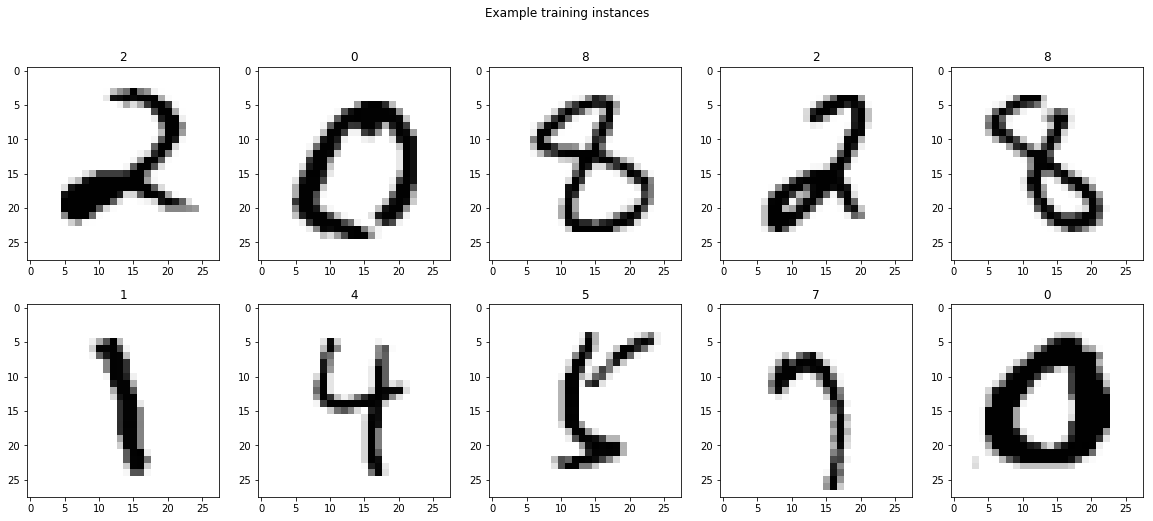

In [7]:
# Plot some generic examples

fig = plt.figure(figsize=(20,8))

for idx in range(10):
    plt.subplot(2,5,idx+1)
    plt.imshow(X_train[idx], cmap=mpl.cm.Greys)
    plt.title(Y_train[idx])
fig.suptitle('Example training instances')
plt.show()

In [8]:
def preprocess_data(X_train, Y_train):
    # Reshape the inputs as row vectors
    X = X_train.reshape(60_000, 28*28)
    
    # One-hot encode the labels
    y = to_categorical(Y_train)
    
    return X, y

In [9]:
X, y = preprocess_data(X_train, Y_train)

## Multiclass logistic regression implemementation

In [13]:
def softmax(scores):
    exp_scores = np.exp(scores - np.max(scores, axis=1, keepdims=True))+1e-6
    return exp_scores / np.sum(exp_scores, axis=1, keepdims=True)

def log_likelihood(X, w, y):
    # Compute softmax predictions
    scores = np.dot(X, w)
    predictions = softmax(scores)
    
    # Log likelihood = 1/N * sum(log p(y_i | x_i))
    ll = np.sum(np.multiply(np.log(predictions), y)) / X.shape[0]
    return ll

def objective(X, w, y):
    log_loss = -log_likelihood(X, w, y)
    l2_norm = np.linalg.norm(w, 'fro')
    return log_loss, l2_norm

def gradient(X, w, y):
    # Compute softmax predictions
    scores = np.dot(X, w)
    predictions = softmax(scores)
    
    # Compute the gradient of the log loss
    grad = np.dot(np.transpose(X), predictions - y) / X.shape[0]
    
    # Compute the gradient of the l2 norm
    l2_grad = 2 * w
    
    return grad, l2_grad

def infer(X, w):
    scores = np.dot(X, w)
    return scores

def accuracy(X, w, y):
    y_hat = np.argmax(infer(X,w), axis=1)
    y = np.argmax(y, axis=1)
    acc = np.sum(np.equal(y, y_hat).astype(np.float32)) / y.shape[0]
    return acc

## Minibatch SGD

Here we perform a generic model fit using "federated" minibatch SGD, i.e. minibatch SGD that doesn't make repeated access to the same data.

In [198]:
def minibatch_sgd(X, y, lmbda=0, eta=0.00005):
    
    M = 10   # Number of machines in each round
    K = 5    # Number of stochastic gradients to calculate on each machine
    R = 100  # Number of rounds
    
    w0 = np.zeros((X.shape[1], y.shape[1]))
    
    w = w0
    next_idx = 0
    log_losses = []
    l2_norms = []
    
    for r in range(R):
        X_batch = X[next_idx:next_idx + K * M]
        y_batch = y[next_idx:next_idx + K * M]
        next_idx += K * M
        
        grad, l2_grad = gradient(X_batch, w, y_batch)
        w = w - eta * (grad + lmbda * l2_grad)
        
        log_loss, l2_norm = objective(X, w, y)
        log_losses.append(log_loss)
        l2_norms.append(l2_norm)
        
    return log_losses, l2_norms, w

In [105]:
log_losses, l2_norms, w = minibatch_sgd(X, y, lmbda=0)

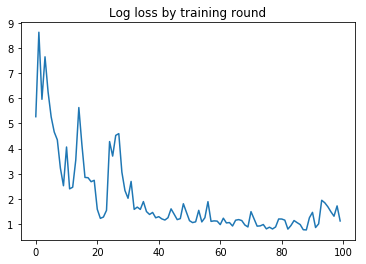

In [88]:
plt.plot(log_losses)
plt.title('Log loss by training round')
plt.show()

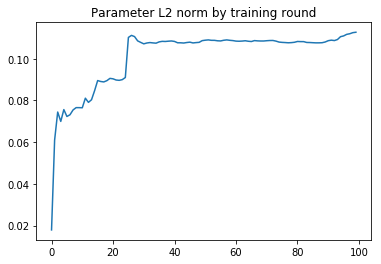

In [89]:
plt.plot(l2_norms)
plt.title('Parameter L2 norm by training round')
plt.show()

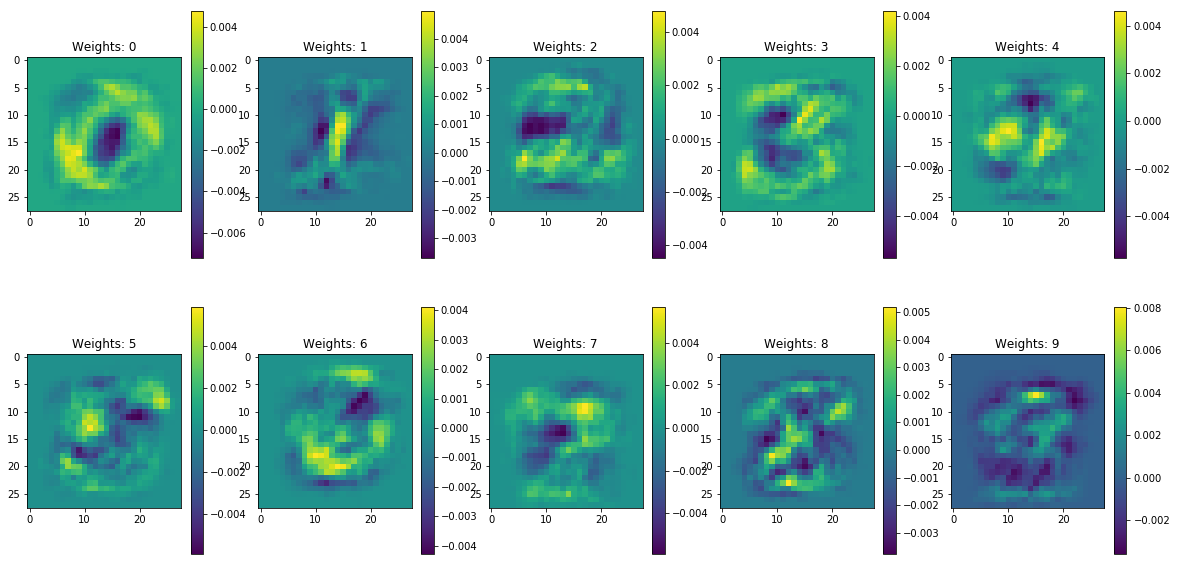

In [90]:
fig = plt.figure(figsize=(20,10))

for idx in range(10):
    plt.subplot(2,5,idx+1)
    plt.imshow(w[:,idx].reshape(28,28))
    plt.colorbar()
    plt.title(f'Weights: {idx}')

Everything looks OK -- getting parameters that look like we expect (you can see the shape of the numbers), and a satisfactory rate of convergence.

## Simulation of distributed nodes

In [53]:
class DataSource:
    """
    Acts like a "button" for random sample data. Reads in the entire sample dataset and stores it locally.
    Then returns data randomly to each machine to prevent re-use of the same data.
    """
    def __init__(self, X, Y):
        self._X = X
        self._Y = Y
        self._num_used = 0

    def generate_observations(self, count):
        X = self._X[self._num_used:self._num_used + count]
        Y = self._Y[self._num_used:self._num_used + count]
        self._num_used += count
        return (X, Y)

class Machine:
    """
    Represents an invididual machine in the network. We will instantiate it with some data,
    ask it to perform some gradient updates and return the results, then forget about this
    machine and the data that was given to it.
    """
    def __init__(self, source, data_count):
        X_local, Y_local = source.generate_observations(data_count)
        self._X = X_local # Locally stored predictor data
        self._Y = Y_local # Locally stored responder data
        self._m = data_count

    def execute_local_SGD(self, eta_inner, w_cur):
        w = np.copy(w_cur)
        grads = []
        for i in range(self._m):
            # Execute the local gradient step:
            grad, _ = gradient(self._X[ [i] ], w, self._Y[ [i] ])
            w = w - eta_inner * grad
            
            grads.append(grad)
        
        # Return the sum of observed gradients
        return np.sum(grads, axis=0)

    def execute_modified_DSVRG(self, w_cur, w_prev, g_prev, eta):
        # Iterate m steps of variance-reduced SGD on the local data
        w = np.copy(w_cur)
        for i in range(self._m):
            # Compute the gradient adjustment for the current iterate:
            # g_(t-1) - nabla f_(k,i)(w_(t-1))
            grad_adjustment = g_prev - gradient(self._X[ [i] ], w_prev, self._Y[ [i] ])[0]
            
            # Execute the variace reduced gradient step:
            w = w - eta * (gradient(self._X[ [i] ], w, self._Y[ [i] ])[0] + grad_adjustment)
            
            # TODO: possibly add gamma shrinkage term
        
        # Compute the local gradient at the iterate where we started the round
        g_local, _ = gradient(self._X, w_cur, self._Y)
        return w, g_local
        

## 1. Inner/outer step size method

### Implementation

In [54]:
def experiment_method_1(X, y, R=100, M=10, k=5, eta_inner=0.001, eta_outer=0.001):
    # Create a DataSource class to avoid repeated use of data
    source = DataSource(X, y)
    
    # Check that we have enough data for the desired experiment
    if R * M * k > X.shape[0]:
        print('Not enough training data')
        return
    
    # Initialize to zero
    w0 = np.zeros((X.shape[1], y.shape[1]))
    ws = [w0]
    
    log_losses = []
    l2_norms = []
    
    # Execute R outer iterations
    for _ in range(R):
        w_cur = ws[-1]
        
        # Generate M random machines to perform the Local SGD steps
        inner_results = [
            Machine(source, data_count=k).execute_local_SGD(eta_inner, w_cur)
        for _ in range(M)]
        
        # Perform the outer gradient step
        w_next = w_cur - eta_outer/M * np.sum(inner_results, axis=0)
        ws.append(w_next)
        
        # Record progress on the objective
        log_loss, l2_norm = objective(X, w_next, y)
        log_losses.append(log_loss)
        l2_norms.append(l2_norm)
    
    return log_losses, l2_norms, ws[-1]

In [76]:
log_losses, l2_norms, w = experiment_method_1(X, y, R=20, M=5, k=100, eta_inner=1e-7, eta_outer=2*1e-7)

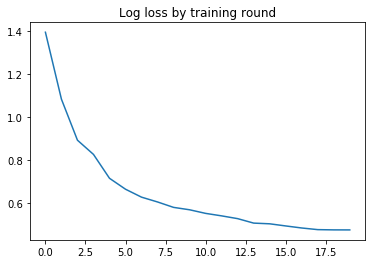

In [77]:
plt.plot(log_losses)
plt.title('Log loss by training round')
plt.show()

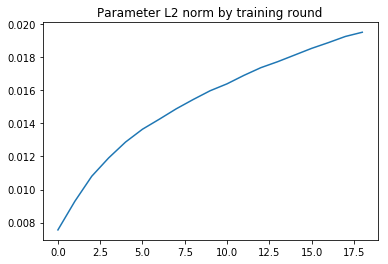

In [78]:
plt.plot(l2_norms[1:])
plt.title('Parameter L2 norm by training round')
plt.show()

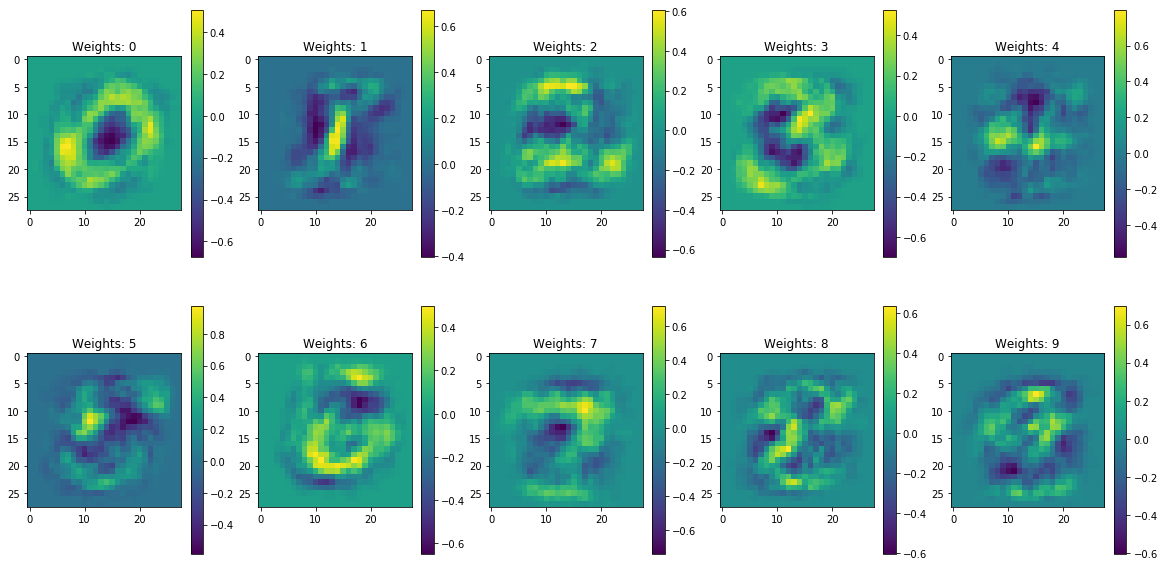

In [197]:
fig = plt.figure(figsize=(20,10))

for idx in range(10):
    plt.subplot(2,5,idx+1)
    plt.imshow(w[:,idx].reshape(28,28))
    plt.colorbar()
    plt.title(f'Weights: {idx}')

### Tuning step sizes

In [171]:
# These dictionaries will store performance data about each run
inner_outer_log_losses = {}
inner_outer_norms = {}

In [191]:
def method_1_tune_outer_step_size(M, k, R, outer_step_sizes, eta_inner=1e-8):
    # R: Rounds
    # M: Machines
    # k: Gradient evals / machine / round

    plt.figure(figsize=(20,10))
    for x in outer_step_sizes:
        log_losses, l2_norms, w = experiment_method_1(X, y, R=R, M=M, k=k, eta_inner=eta_inner, eta_outer=x)
        plt.plot(log_losses, label=f'eta_outer={x}')

    plt.legend()
    plt.title(f'Tuning outer step size: R={R}, M={M}, K={k}', fontsize=20)
    plt.xlabel('Round of communication')
    plt.ylabel('Objective value')
    plt.show()

def method_1_tune_inner_step_size(M, k, R, inner_step_sizes, eta_outer):
    plt.figure(figsize=(20,10))
    for x in inner_step_sizes:
        eta_inner = x * eta_outer
        log_losses, l2_norms, w = experiment_method_1(X, y, R=R, M=M, k=k, eta_inner=eta_inner, eta_outer=eta_outer)
        plt.plot(log_losses, label=f'eta_inner={x}')

        # Store performance data for future comparison
        key = (M, k, R, x)
        inner_outer_log_losses[key] = log_losses
        inner_outer_norms[key] = l2_norms

    plt.legend()
    plt.title(f'Tuning inner step size: R={R}, M={M}, K={k}, eta_outer={eta_outer}', fontsize=20)
    plt.xlabel('Round of communication')
    plt.ylabel('Objective value')
    plt.show()

## Small K regime: K=5, R=100

### M=5

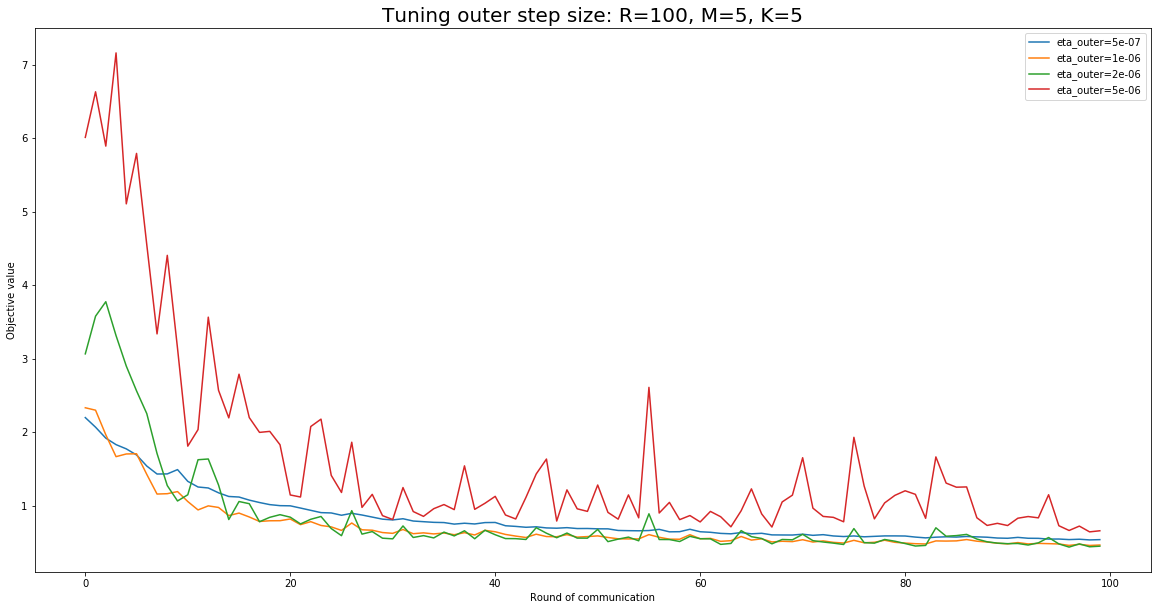

In [177]:
R = 100  # Rounds
M = 5    # Machines
k = 5    # Gradient evals / machine / round

outer_step_sizes = [5e-7, 1e-6, 2e-6, 5e-6]
eta_inner = 1e-8

method_1_tune_outer_step_size(M, k, R, outer_step_sizes, eta_inner)

The graphic above suggests $\eta_{\text{outer}} = 1e-6$ is a reasonable outer step size to proceed with.

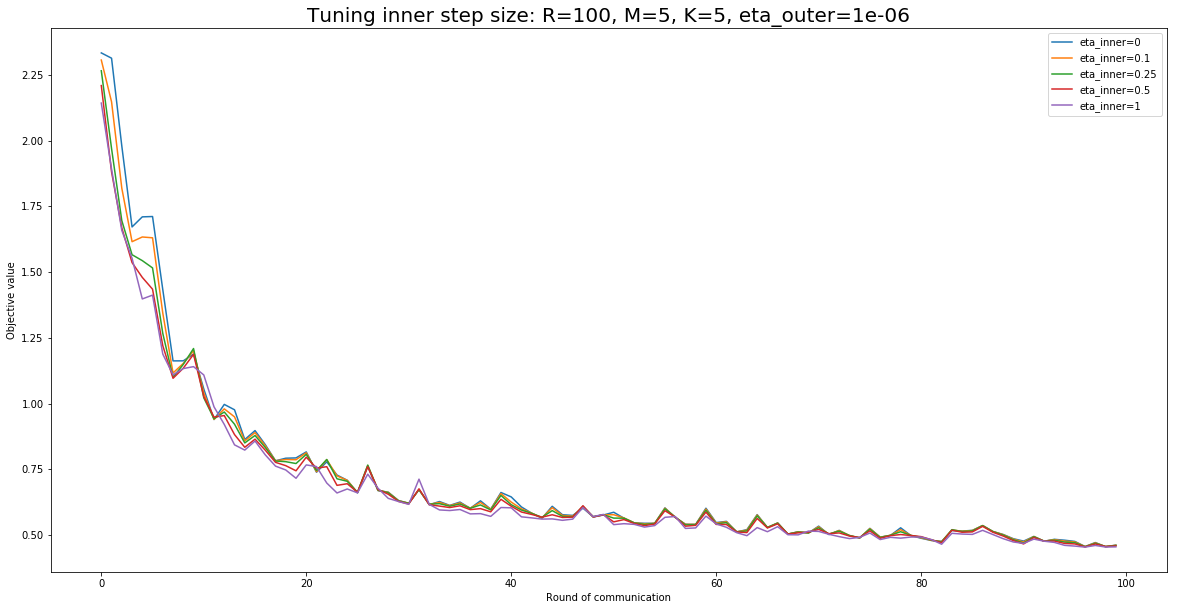

In [179]:
R = 100  # Rounds
M = 5    # Machines
k = 5    # Gradient evals / machine / round

# Inner step sizes to test as (a fraction of outer step size)
inner_step_sizes = [0, .1, .25, .5, 1]
eta_outer = 1e-6
`
method_1_tune_inner_step_size(M, k, R, inner_step_sizes, eta_outer)

The plot above suggests something interesting: in the early rounds, a positive inner step size helps (and the largest inner step sizes are the best two performers), whereas in the later rounds the large inner step size appears as more of a handicap. I suspect that local steps help early on when there is large improvement to be made with few steps; later in the optimization, the local steps add excess variance. However, there also seems to be a sweet spot here, with $\eta_{\text{inner}} \approx 1e-6$ performing well in both the early and late rounds.

Possible improvements:
* Use a decaying inner step size schedule
* Use a variance reduction technique on the inner steps

### M=50

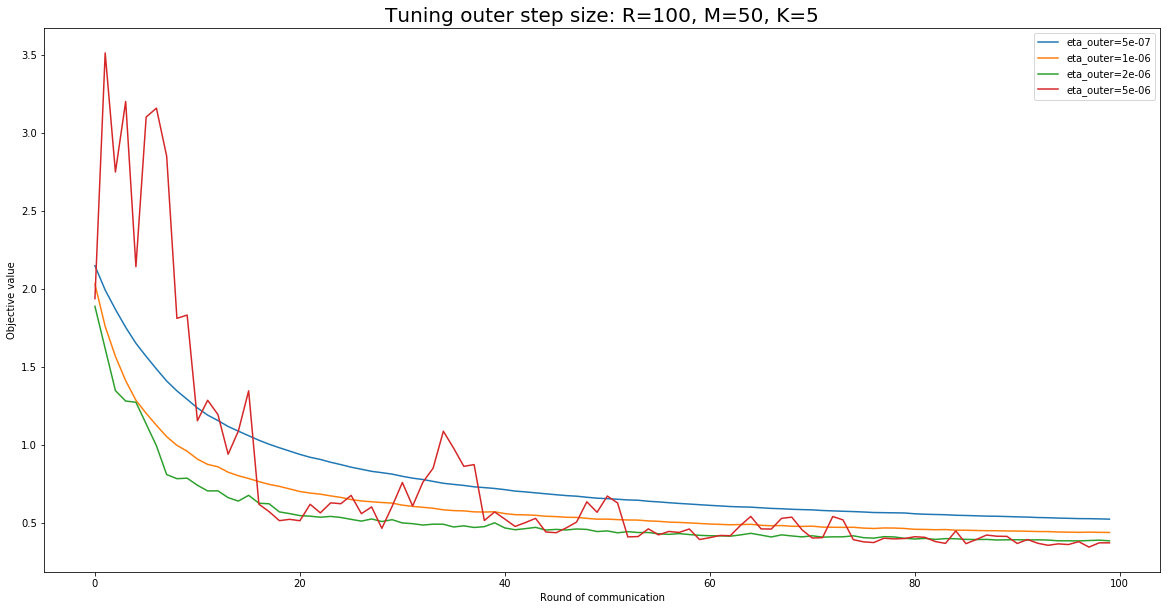

In [180]:
R = 100  # Rounds
M = 50   # Machines
k = 5    # Gradient evals / machine / round

outer_step_sizes = [5e-7, 1e-6, 2e-6, 5e-6]
eta_inner = 1e-8

method_1_tune_outer_step_size(M, k, R, outer_step_sizes, eta_inner)

The graphic above suggests $\eta_{\text{outer}} = 2e-6$ is a reasonable outer step size to proceed with.

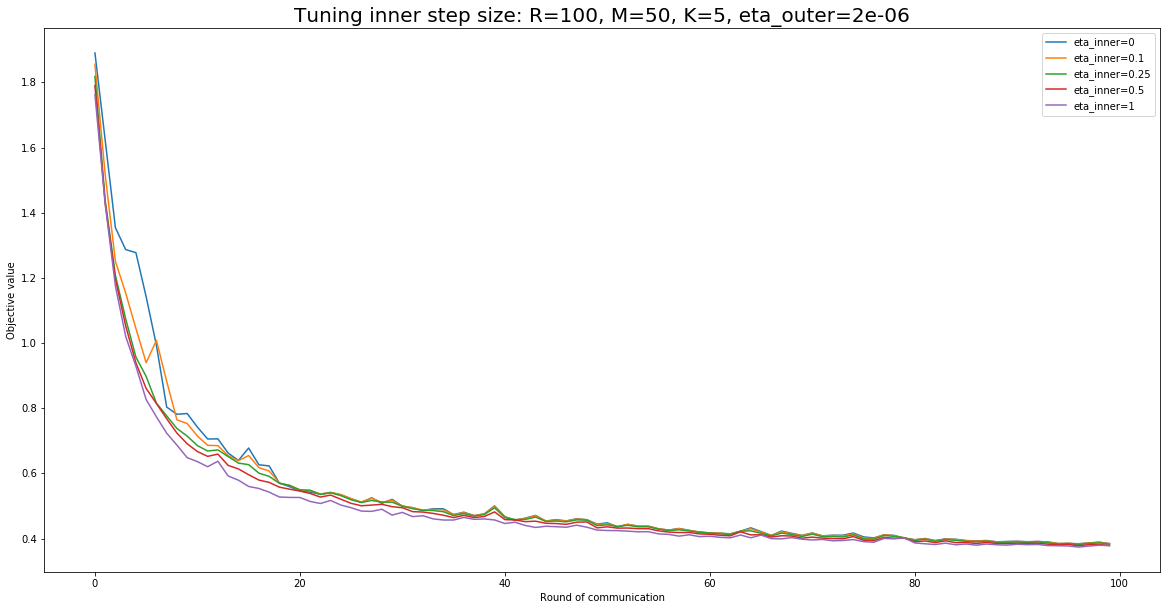

In [181]:
R = 100  # Rounds
M = 50   # Machines
k = 5    # Gradient evals / machine / round

# Inner step sizes to test (as a fraction of outer step size)
inner_step_sizes = [0, .1, .25, .5, 1]
eta_outer = 2e-6

method_1_tune_inner_step_size(M, k, R, inner_step_sizes, eta_outer)

## Medium K regime: K=25, R=40

### M=5

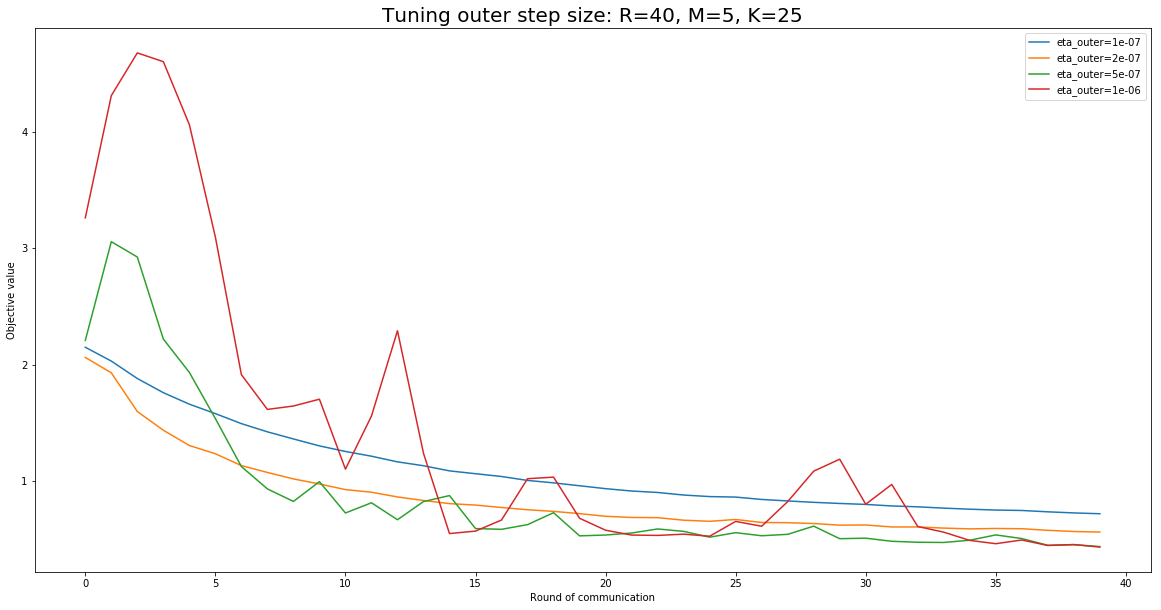

In [187]:
R = 40   # Rounds
M = 5    # Machines
k = 25   # Gradient evals / machine / round

outer_step_sizes = [1e-7, 2e-7, 5e-7, 1e-6]
eta_inner = 1e-8

method_1_tune_outer_step_size(M, k, R, outer_step_sizes, eta_inner)

The best apparent outer step size is 5e-7.

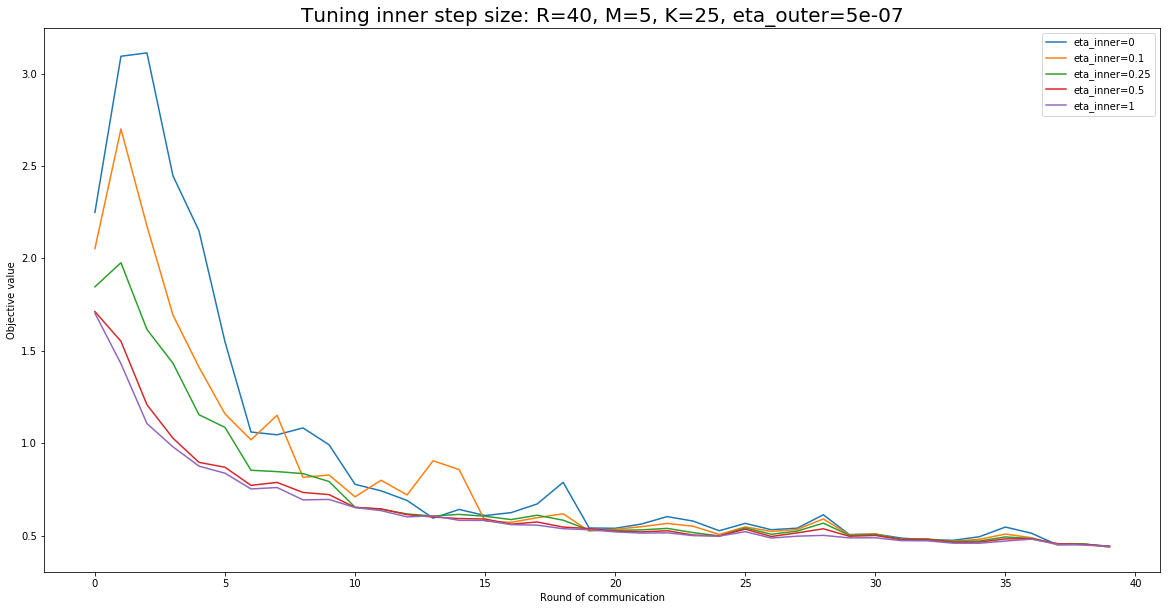

In [189]:
R = 40   # Rounds
M = 5    # Machines
k = 25   # Gradient evals / machine / round

# Inner step sizes to test as a fraction of outer step size
inner_step_sizes = [0, .1, .25, .5, 1]
eta_outer = 5e-7

method_1_tune_inner_step_size(M, k, R, inner_step_sizes, eta_outer)

### M = 50

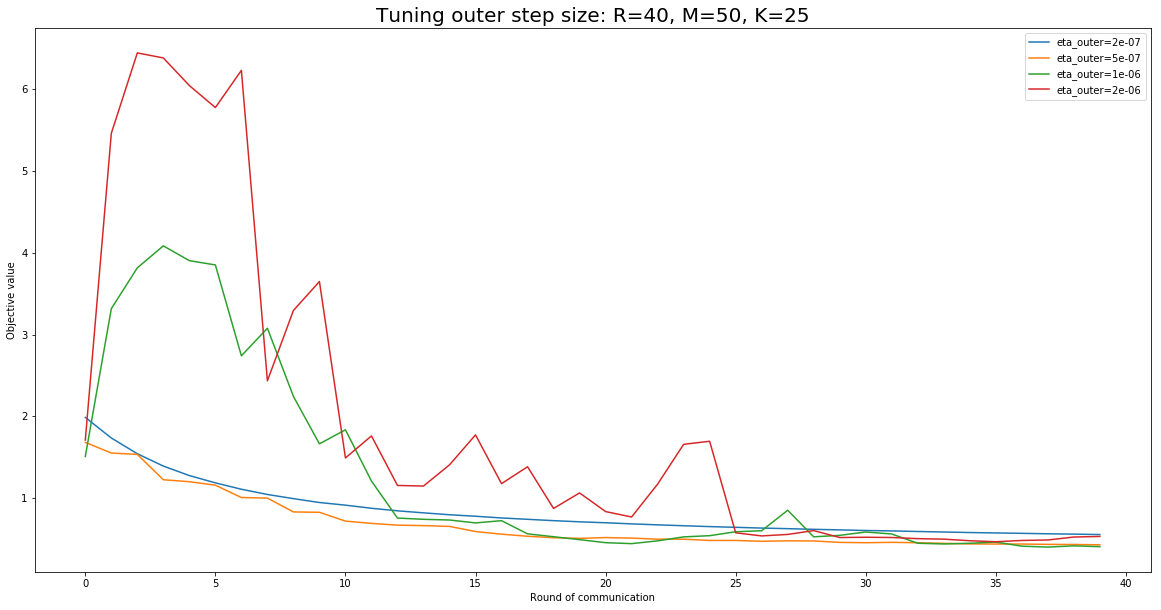

In [190]:
R = 40   # Rounds
M = 50   # Machines
k = 25   # Gradient evals / machine / round

outer_step_sizes = [2e-7, 5e-7, 1e-6, 2e-6]
eta_inner = 1e-8

method_1_tune_outer_step_size(M, k, R, outer_step_sizes, eta_inner)

The best apparent step size is 5e-7.

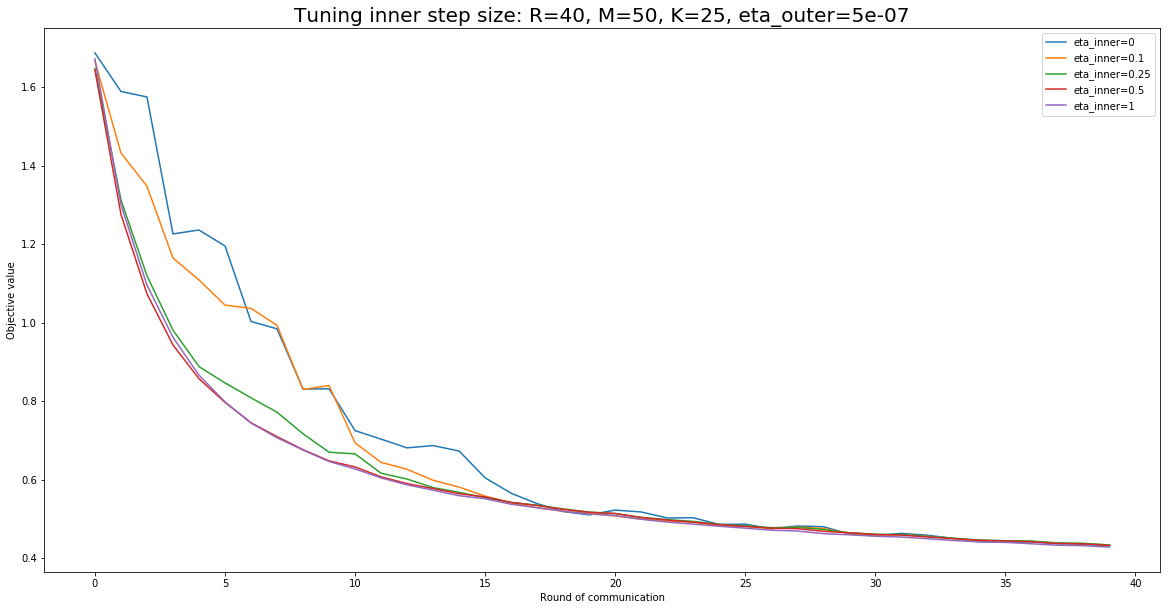

In [192]:
R = 40   # Rounds
M = 50   # Machines
k = 25   # Gradient evals / machine / round

# Inner step sizes to test as a fraction of outer step size
inner_step_sizes = [0, .1, .25, .5, 1]
eta_outer = 5e-7

method_1_tune_inner_step_size(M, k, R, inner_step_sizes, eta_outer)

### Large K regime: K=100, R=10

### M=5

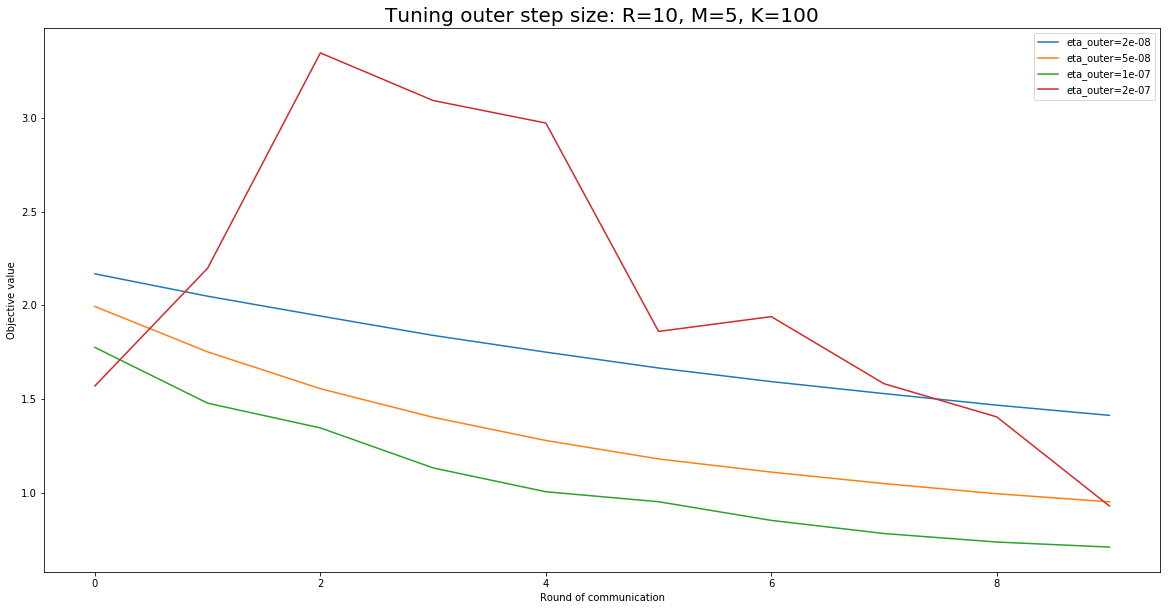

In [194]:
R = 10   # Rounds
M = 5    # Machines
k = 100  # Gradient evals / machine / round

outer_step_sizes = [2e-8, 5e-8, 1e-7, 2e-7]
eta_inner = 1e-8

method_1_tune_outer_step_size(M, k, R, outer_step_sizes, eta_inner)

This suggests a step size of 1e-7.

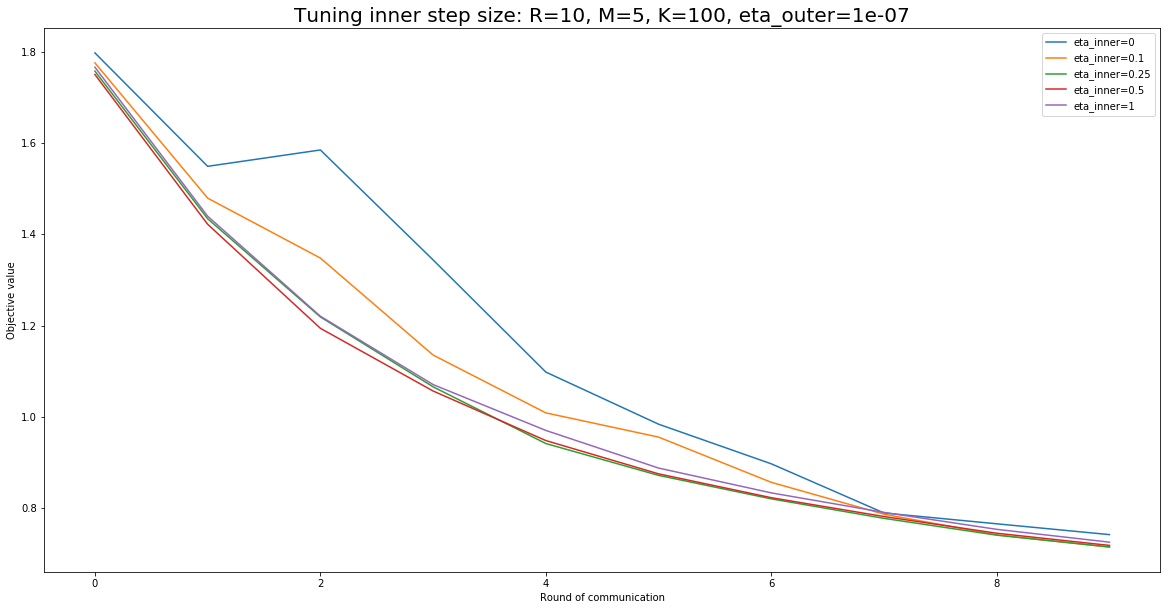

In [195]:
R = 10   # Rounds
M = 5    # Machines
k = 100  # Gradient evals / machine / round

# Inner step sizes to test as a fraction of outer step size
inner_step_sizes = [0, .1, .25, .5, 1]
eta_outer = 1e-7

method_1_tune_inner_step_size(M, k, R, inner_step_sizes, eta_outer)

Note: this is the first time we can visibly see the intermediate step size outperforming local SGD.

### M=50

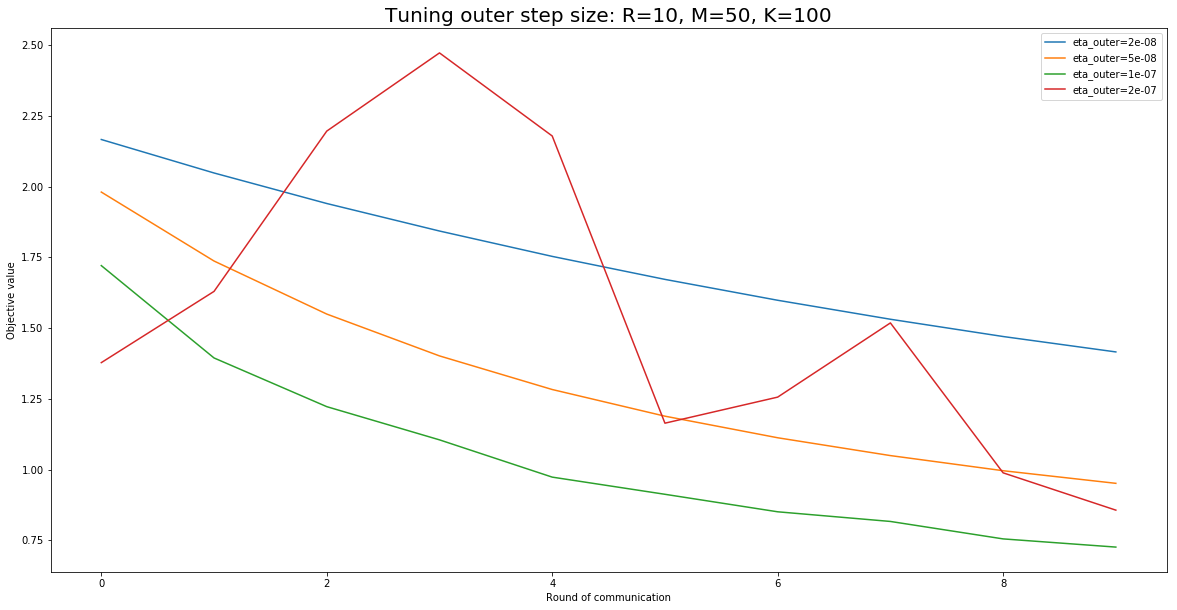

In [197]:
R = 10   # Rounds
M = 50   # Machines
k = 100  # Gradient evals / machine / round

outer_step_sizes = [2e-8, 5e-8, 1e-7, 2e-7]
eta_inner = 1e-8

method_1_tune_outer_step_size(M, k, R, outer_step_sizes, eta_inner)

We again go with 1e-07.

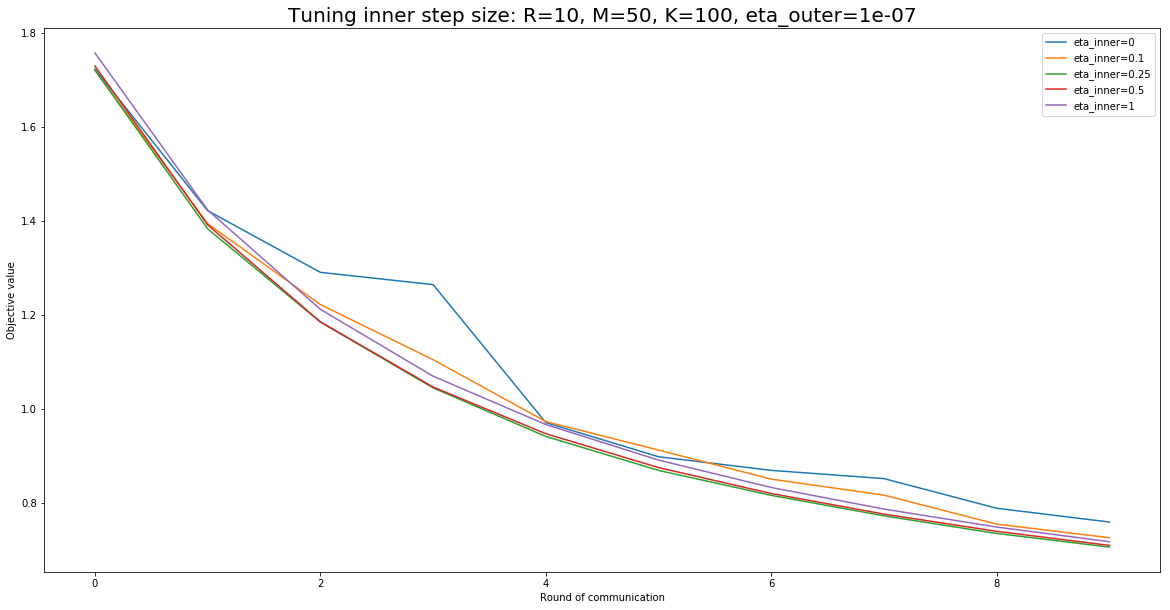

In [198]:
R = 10   # Rounds
M = 50   # Machines
k = 100  # Gradient evals / machine / round

# Inner step sizes to test as a fraction of outer step size
inner_step_sizes = [0, .1, .25, .5, 1]
eta_outer = 1e-7

method_1_tune_inner_step_size(M, k, R, inner_step_sizes, eta_outer)

The above graph suggests what we expect: When R is small and K is large, a positive inner step size helps. It looks like $\eta_{\text{inner}} = 5e-7$ is approximately the winner. Why does the zero inner step size do so badly? I suspect this is because in the first few rounds it is making a lot of gradient estimates at degenerate locations (starting with the origin). Depending on the function curvature this could lead it to either overshoot (suppose very steep gradient near the origin) or move toward a bad local minimum.

By contrast, performing inner steps lets each machine get to a "reasonable" parameter estimate within the first few rounds, and then continue making non-degenerate gradient estimates from there.

Despite a bad first three rounds, the minibatch approach still performs well after 20 rounds. This observation suggests that an optimal approach may want to consider decaying the inner step size.

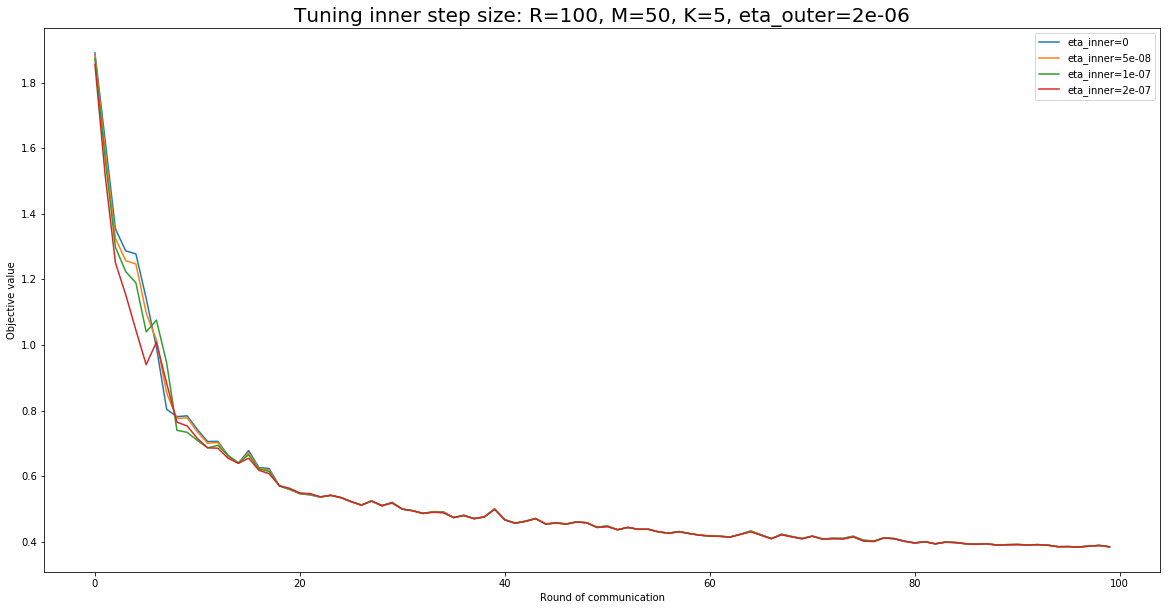

In [134]:
R = 100   # Rounds
M = 50    # Machines
k = 5     # Gradient evals / machine / round

inner_step_sizes = [0, 5e-8, 1e-7, 2e-7] #, 5e-5, 1e-4, 5e-4, 1e-3] ]
eta_outer = 2e-6 #

plt.figure(figsize=(20,10))
for x in inner_step_sizes:
    log_losses, l2_norms, w = experiment_method_1(X, y, R=R, M=M, k=k, eta_inner=x, eta_outer=eta_outer)
    plt.plot(log_losses, label=f'eta_inner={x}')

plt.legend()
plt.title(f'Tuning inner step size: R={R}, M={M}, K={k}, eta_outer={eta_outer}', fontsize=20)
plt.xlabel('Round of communication')
plt.ylabel('Objective value')
plt.show()

## 2. Modified DSVRG method

### Implementation

In [1]:
def experiment_method_2(X, y, T=100, K=5, m=100, eta=0.001):
    # Create a DataSource class to avoid repeated use of data
    source = DataSource(X, y)
    
    # Check that we have enough data for the desired experiment
    if T * K * m > X.shape[0]:
        print('Not enough training data')
        return
    
    # Initialize to zero
    w0 = np.zeros((X.shape[1], y.shape[1]))
    g0 = np.zeros((X.shape[1], y.shape[1]))
    
    ws = [w0, w0]
    gs = [g0]
    
    log_losses = []
    l2_norms = []
    
    # Execute T outer iterations
    for _ in range(T):
        w_cur = ws[-1]
        w_prev = ws[-2]
        g_prev = gs[-1]
        
        # Generate K random machines to perform the modified DSVRG inner iteration updates
        inner_results = [
            Machine(source, data_count=m).execute_modified_DSVRG(w_cur, w_prev, g_prev, eta)
        for _ in range(K)]
        
        # Compute the next iterate, and the reference gradient
        w_next = np.mean([w for (w, _) in inner_results], axis=0)
        g_cur = np.mean([g for (_, g) in inner_results], axis=0)

        ws.append(w_next)
        gs.append(g_cur)
        
        # Record progress on the objective
        log_loss, l2_norm = objective(X, w_next, y)
        log_losses.append(log_loss)
        l2_norms.append(l2_norm)
    
    return log_losses, l2_norms, ws[-1]

In [14]:
log_losses, l2_norms, w = experiment_method_2(X, y, eta=1e-6)

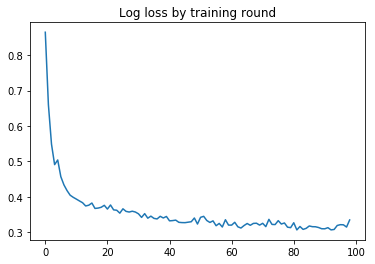

In [15]:
plt.plot(log_losses[1:])
plt.title('Log loss by training round')
plt.show()

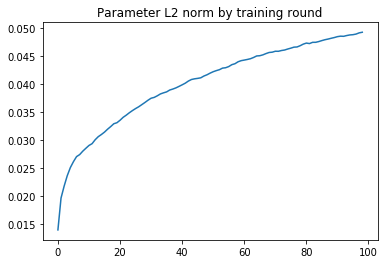

In [16]:
plt.plot(l2_norms[1:])
plt.title('Parameter L2 norm by training round')
plt.show()

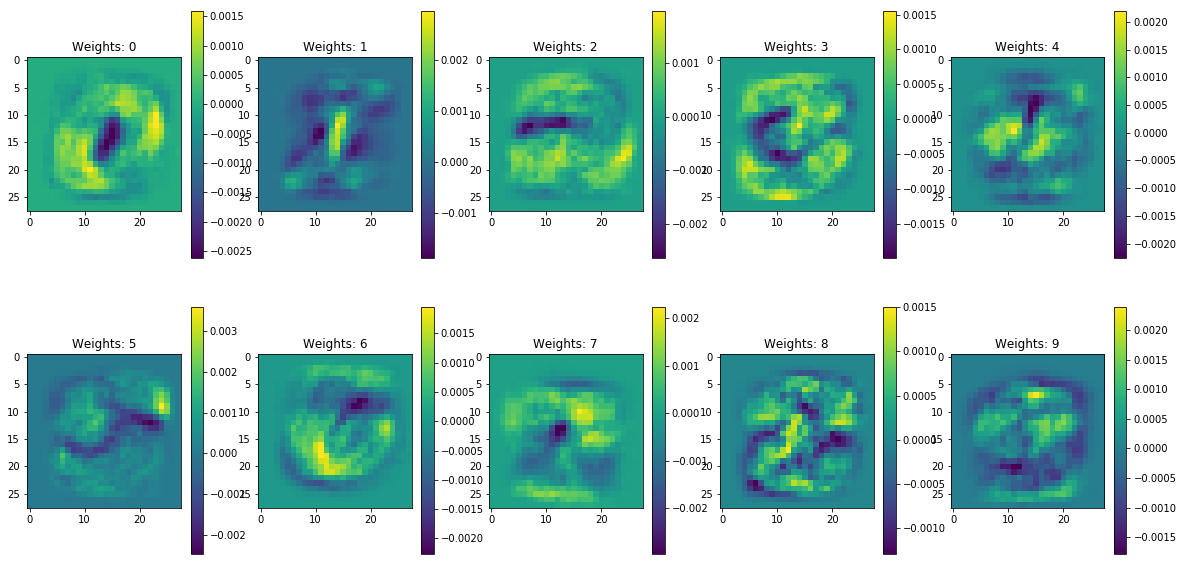

In [17]:
fig = plt.figure(figsize=(20,10))

for idx in range(10):
    plt.subplot(2,5,idx+1)
    plt.imshow(w[:,idx].reshape(28,28))
    plt.colorbar()
    plt.title(f'Weights: {idx}')

## Tuning the step size

In [157]:
# These dictionaries will store performance data about each run
var_reduced_log_losses = {}
var_reduced_norms = {}

## Small K regime: K = 5, R = 100

### M = 5

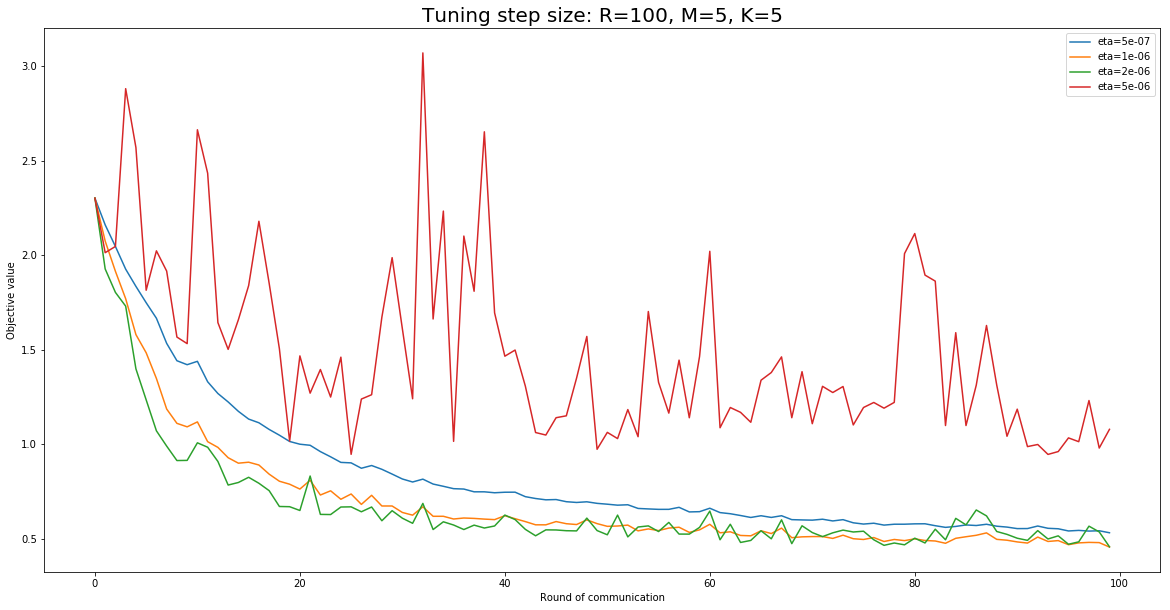

In [158]:
R = 100  # Rounds
M = 5    # Machines
k = 5    # Gradient evals / machine / round

step_sizes = [5e-7, 1e-6, 2e-6, 5e-6]

plt.figure(figsize=(20,10))
for x in step_sizes:
    log_losses, l2_norms, w = experiment_method_2(X, y, T=R, K=M, m=k, eta=x)
    plt.plot(log_losses, label=f'eta={x}')
    
    # Store performance data for future comparison
    key = (M, k, R, x)
    var_reduced_log_losses[key] = log_losses
    var_reduced_norms[key] = l2_norms

plt.legend()
plt.title(f'Tuning step size: R={R}, M={M}, K={k}', fontsize=20)
plt.xlabel('Round of communication')
plt.ylabel('Objective value')
plt.show()

The optimal step size is around 1e-6.

### M = 50

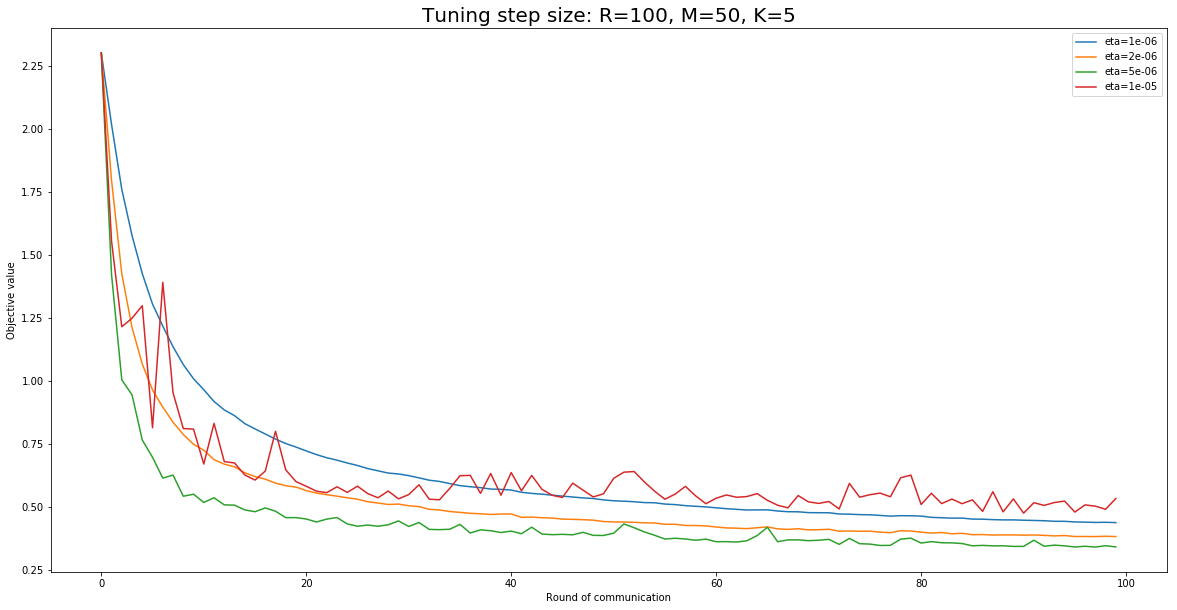

In [160]:
R = 100  # Rounds
M = 50   # Machines
k = 5    # Gradient evals / machine / round

step_sizes = [1e-6, 2e-6, 5e-6, 1e-5]

plt.figure(figsize=(20,10))
for x in step_sizes:
    log_losses, l2_norms, w = experiment_method_2(X, y, T=R, K=M, m=k, eta=x)
    plt.plot(log_losses, label=f'eta={x}')
    
    # Store performance data for future comparison
    key = (M, k, R, x)
    var_reduced_log_losses[key] = log_losses
    var_reduced_norms[key] = l2_norms

plt.legend()
plt.title(f'Tuning step size: R={R}, M={M}, K={k}', fontsize=20)
plt.xlabel('Round of communication')
plt.ylabel('Objective value')
plt.show()

The optimal step size is around 5e-6.

## Medium K regime: K = 25, R = 40

### M = 5

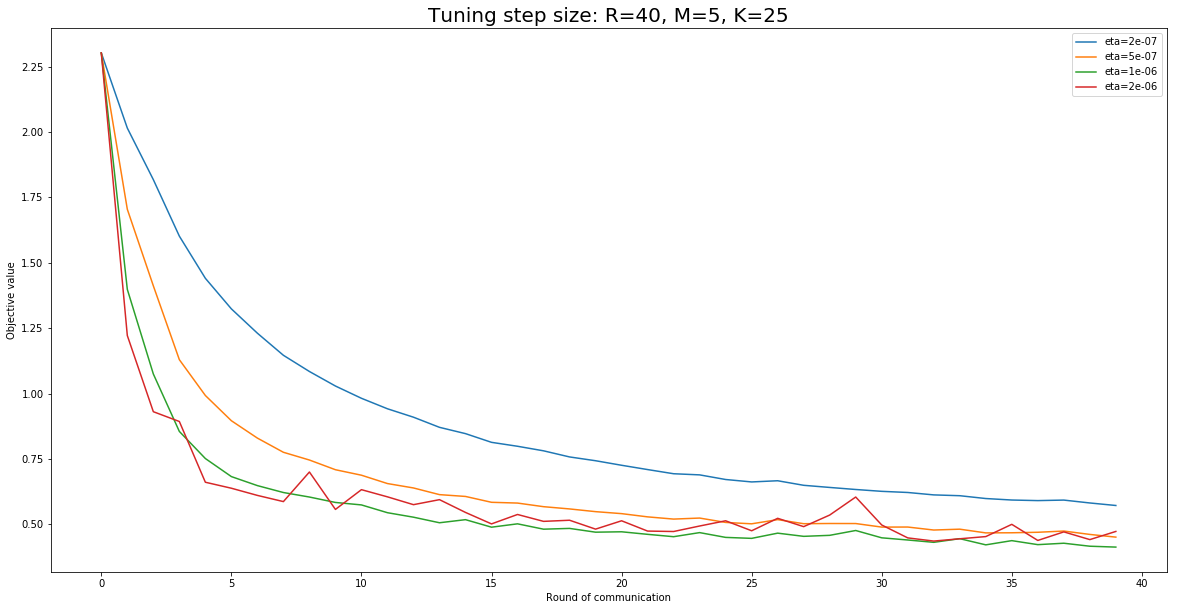

In [161]:
R = 40   # Rounds
M = 5    # Machines
k = 25   # Gradient evals / machine / round

step_sizes = [2e-7, 5e-7, 1e-6, 2e-6]

plt.figure(figsize=(20,10))
for x in step_sizes:
    log_losses, l2_norms, w = experiment_method_2(X, y, T=R, K=M, m=k, eta=x)
    plt.plot(log_losses, label=f'eta={x}')
    
    # Store performance data for future comparison
    key = (M, k, R, x)
    var_reduced_log_losses[key] = log_losses
    var_reduced_norms[key] = l2_norms

plt.legend()
plt.title(f'Tuning step size: R={R}, M={M}, K={k}', fontsize=20)
plt.xlabel('Round of communication')
plt.ylabel('Objective value')
plt.show()

The optimal step size is around 1e-6.

### M = 50

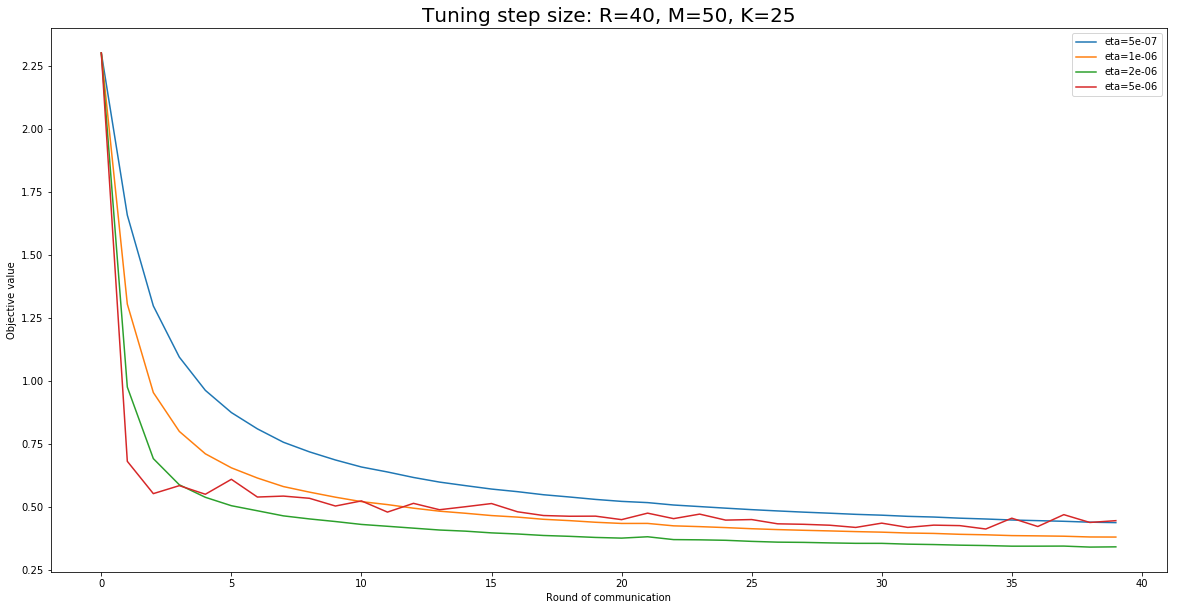

In [162]:
R = 40   # Rounds
M = 50    # Machines
k = 25   # Gradient evals / machine / round

step_sizes = [5e-7, 1e-6, 2e-6, 5e-6]

plt.figure(figsize=(20,10))
for x in step_sizes:
    log_losses, l2_norms, w = experiment_method_2(X, y, T=R, K=M, m=k, eta=x)
    plt.plot(log_losses, label=f'eta={x}')
    
    # Store performance data for future comparison
    key = (M, k, R, x)
    var_reduced_log_losses[key] = log_losses
    var_reduced_norms[key] = l2_norms

plt.legend()
plt.title(f'Tuning step size: R={R}, M={M}, K={k}', fontsize=20)
plt.xlabel('Round of communication')
plt.ylabel('Objective value')
plt.show()

The optimal step size is about 2e-6.

## Large K regime: K = 100, R = 10

### M = 5

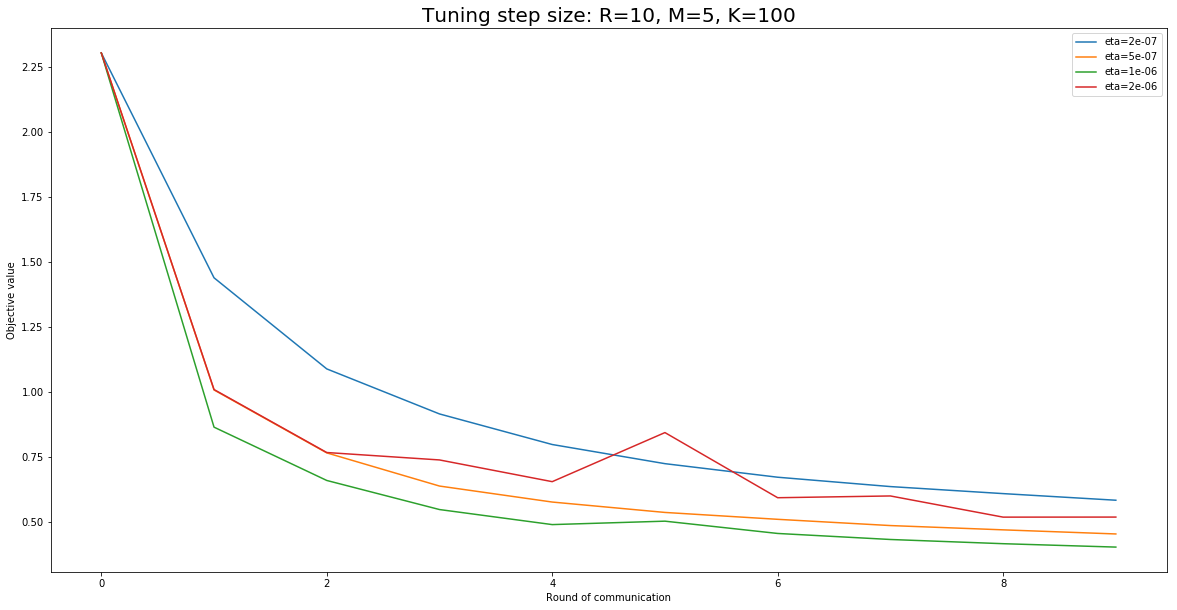

In [163]:
R = 10   # Rounds
M = 5    # Machines
k = 100  # Gradient evals / machine / round

step_sizes = [2e-7, 5e-7, 1e-6, 2e-6]

plt.figure(figsize=(20,10))
for x in step_sizes:
    log_losses, l2_norms, w = experiment_method_2(X, y, T=R, K=M, m=k, eta=x)
    plt.plot(log_losses, label=f'eta={x}')
    
    # Store performance data for future comparison
    key = (M, k, R, x)
    var_reduced_log_losses[key] = log_losses
    var_reduced_norms[key] = l2_norms

plt.legend()
plt.title(f'Tuning step size: R={R}, M={M}, K={k}', fontsize=20)
plt.xlabel('Round of communication')
plt.ylabel('Objective value')
plt.show()

The optimal step size is about 1e-6.

### M = 50

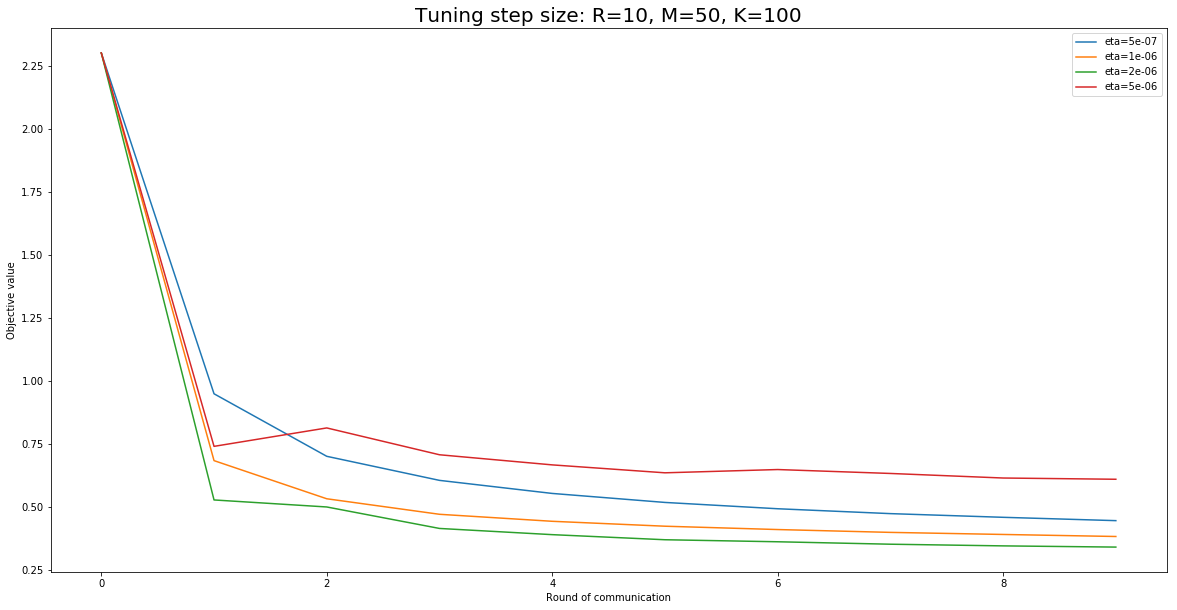

In [164]:
R = 10   # Rounds
M = 50   # Machines
k = 100  # Gradient evals / machine / round

step_sizes = [5e-7, 1e-6, 2e-6, 5e-6]

plt.figure(figsize=(20,10))
for x in step_sizes:
    log_losses, l2_norms, w = experiment_method_2(X, y, T=R, K=M, m=k, eta=x)
    plt.plot(log_losses, label=f'eta={x}')
    
    # Store performance data for future comparison
    key = (M, k, R, x)
    var_reduced_log_losses[key] = log_losses
    var_reduced_norms[key] = l2_norms

plt.legend()
plt.title(f'Tuning step size: R={R}, M={M}, K={k}', fontsize=20)
plt.xlabel('Round of communication')
plt.ylabel('Objective value')
plt.show()

The optimal step size is about 2e-6.

## Comparing performance across methods

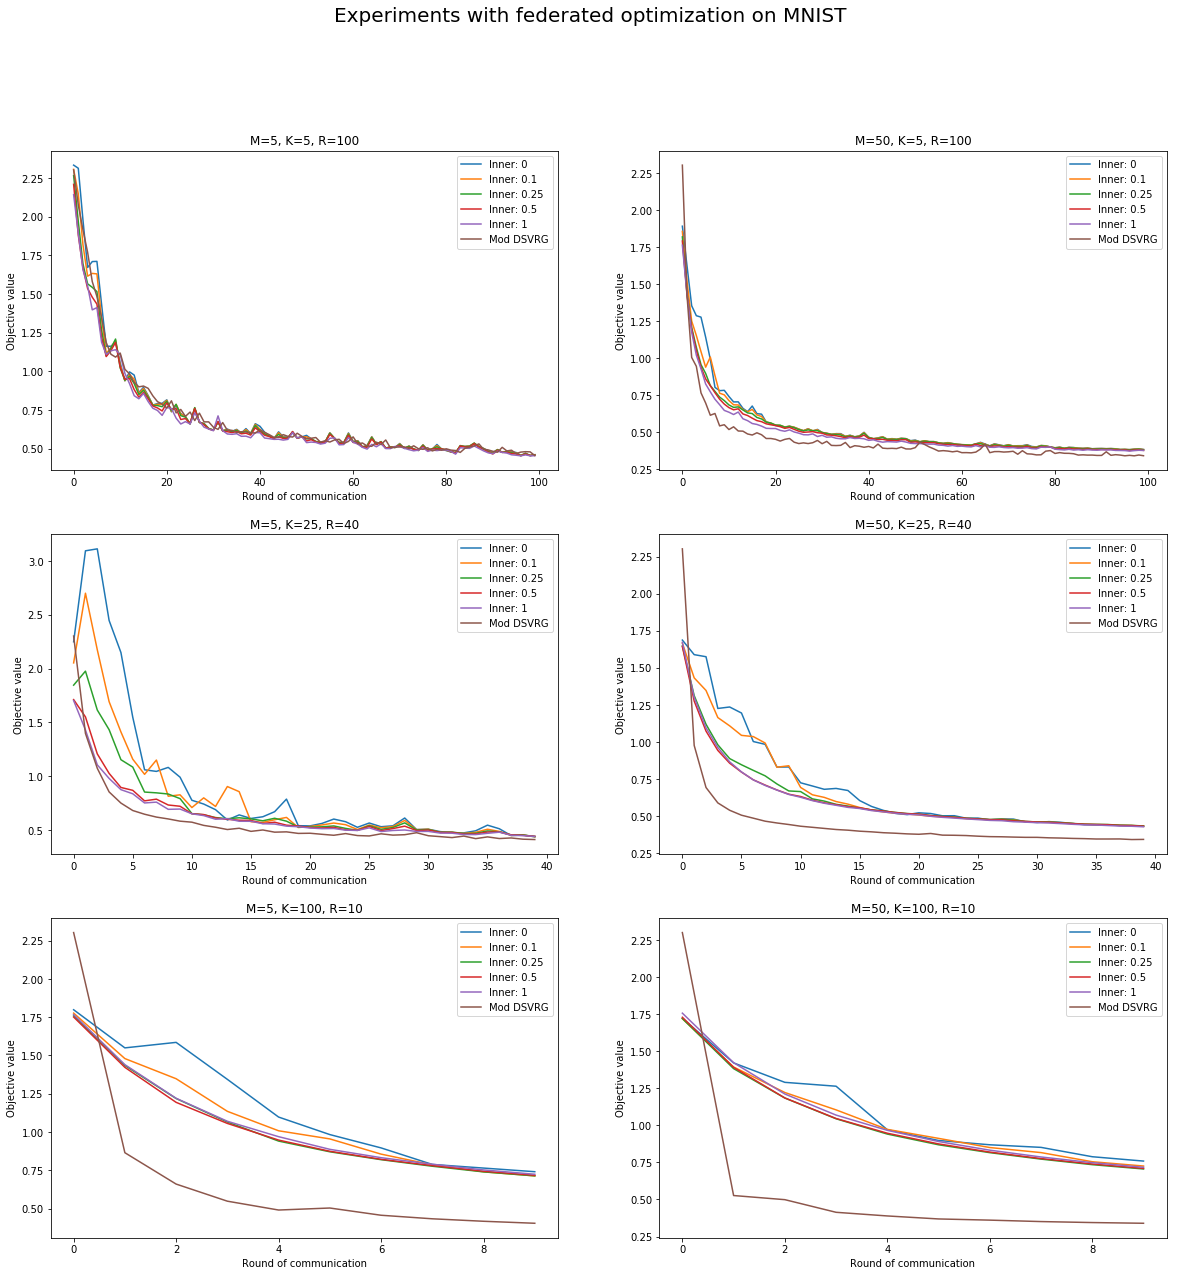

In [203]:
fig, axs = plt.subplots(3, 2, figsize=(20,20))
fig.suptitle('Experiments with federated optimization on MNIST', fontsize=20)

# Numbers of machines to use in each round
machine_specs = [
    5,
    50,
]

# Configurations of (K, R) to try
communication_specs = [
    (5, 100),
    (25, 40),
    (100, 10),
]

# Optimal step sizes
# maps (M, K, R) -> optimal step size
var_reduced_step_sizes = {
    (5,  5, 100):   1e-6,
    (50, 5, 100):   5e-6,
    (5,  25, 40):   1e-6,
    (50, 25, 40):   2e-6,
    (5,  100, 10):  1e-6,
    (50, 100, 10):  2e-6,
}

# Inner step sizes to try as a fraction of the outer step size
inner_step_sizes = [0, .1, .25, .5, 1]

for i in range(3):
    for j in range(2):
        M = machine_specs[j]
        k, R = communication_specs[i]
        
        # Plot the result for various inner step sizes
        for x in inner_step_sizes:
            key = (M, k, R, x)
            log_losses = inner_outer_log_losses[key]
            axs[i][j].plot(log_losses, label=f'Inner: {x}')
        
        
        # Plot the result for the reduced variance method
        step_size = var_reduced_step_sizes[(M, k, R)]
        key = (M, k, R, step_size)
        log_losses = var_reduced_log_losses[key]
        axs[i][j].plot(log_losses, label='Mod DSVRG')
        
        axs[i][j].set_title(f'M={M}, K={k}, R={R}')
        axs[i][j].set_xlabel('Round of communication')
        axs[i][j].set_ylabel('Objective value')
        axs[i][j].legend()

plt.show()

Observations
* Mod. DSVRG almost everywhere dominates all of the other methods
* The advantage of Mod. DSVRG is particularly apparent when M is large
* Larger inner step sizes tend to outperform smaller inner step sizes
* However, in the large K regime, inner=0.5*outer shows a slight advantage over local SGD

Comparing the norm of the parameter across models

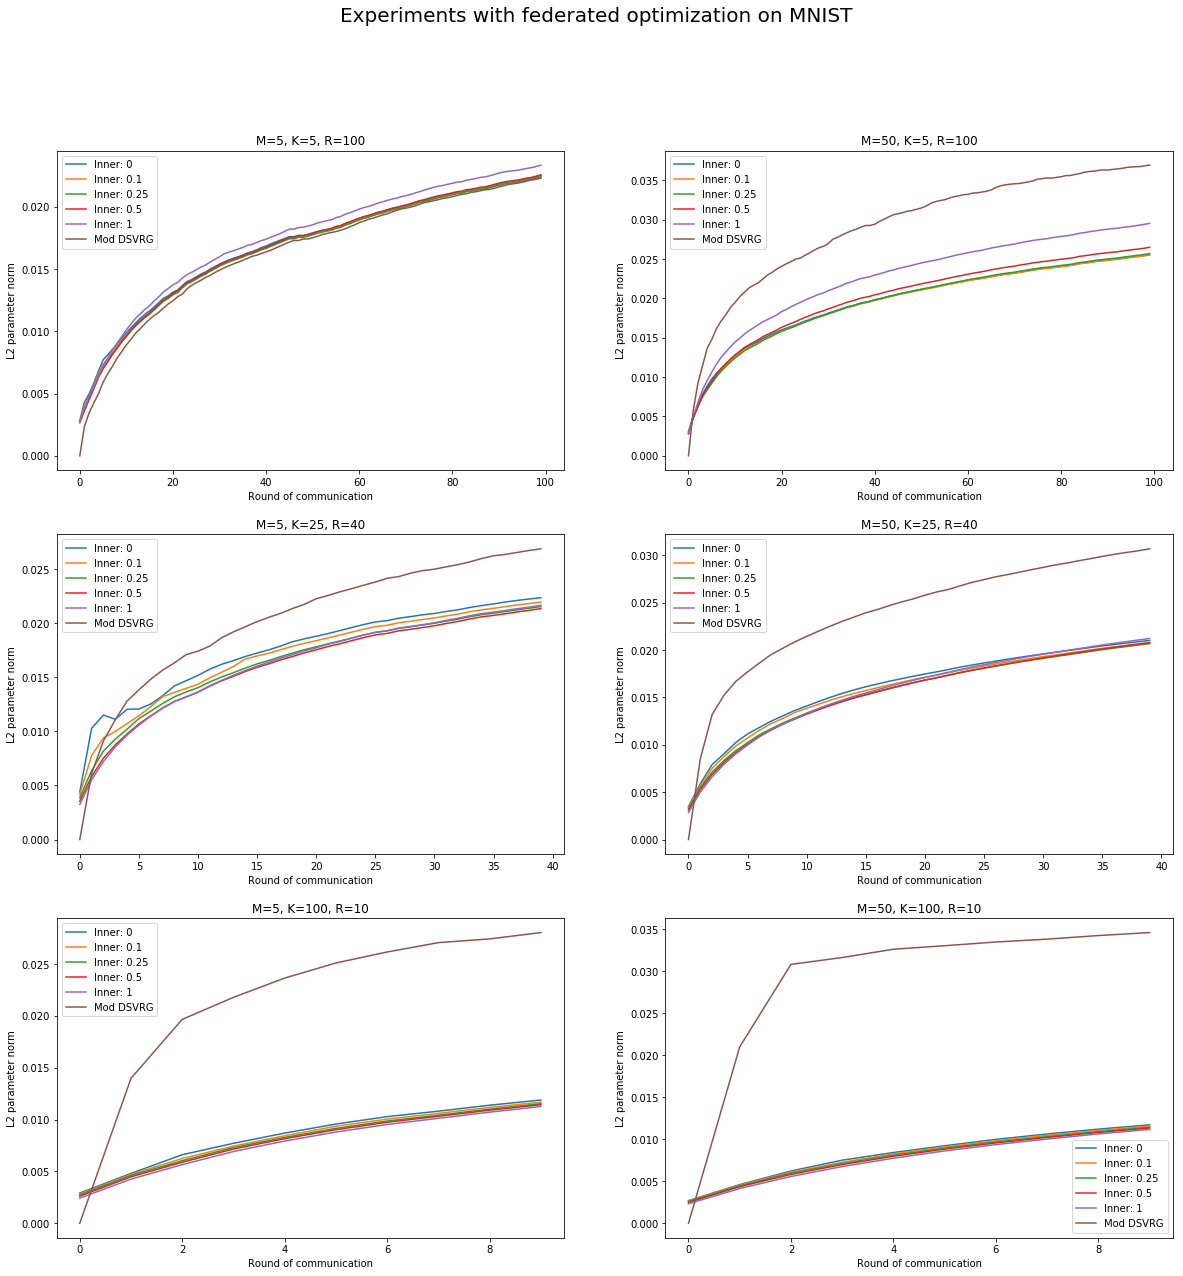

In [209]:
fig, axs = plt.subplots(3, 2, figsize=(20,20))
fig.suptitle('Experiments with federated optimization on MNIST', fontsize=20)

# Numbers of machines to use in each round
machine_specs = [
    5,
    50,
]

# Configurations of (K, R) to try
communication_specs = [
    (5, 100),
    (25, 40),
    (100, 10),
]

# Optimal step sizes for each Mod DSVRG case
# maps (M, K, R) -> optimal step size
var_reduced_step_sizes = {
    (5,  5, 100):   1e-6,
    (50, 5, 100):   5e-6,
    (5,  25, 40):   1e-6,
    (50, 25, 40):   2e-6,
    (5,  100, 10):  1e-6,
    (50, 100, 10):  2e-6,
}

# Inner step sizes to try as a fraction of the outer step size
inner_step_sizes = [0, .1, .25, .5, 1]

for i in range(3):
    for j in range(2):
        M = machine_specs[j]
        k, R = communication_specs[i]
        
        # Plot the result for various inner step sizes
        for x in inner_step_sizes:
            key = (M, k, R, x)
            norms = inner_outer_norms[key]
            axs[i][j].plot(norms, label=f'Inner: {x}')
        
        
        # Plot the result for the reduced variance method
        step_size = var_reduced_step_sizes[(M, k, R)]
        key = (M, k, R, step_size)
        norms = var_reduced_norms[key]
        axs[i][j].plot(norms, label='Mod DSVRG')
        
        axs[i][j].set_title(f'M={M}, K={k}, R={R}')
        axs[i][j].set_xlabel('Round of communication')
        axs[i][j].set_ylabel('L2 parameter norm')
        axs[i][j].legend()

plt.show()

## An observed case where partial inner step sizes improve on both Minibatch and Local SGD

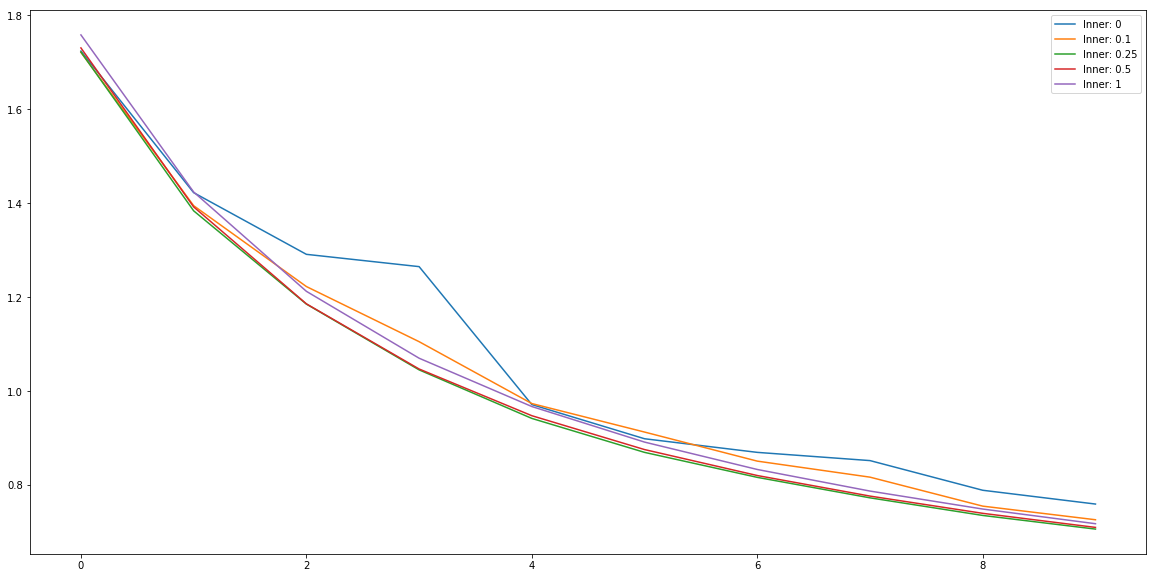

In [217]:
R=10
M=50
k=100

plt.figure(figsize=(20,10))

inner_step_sizes = [0, .1, .25, .5, 1]
for x in inner_step_sizes:
    key = (M, k, R, x)
    log_losses = inner_outer_log_losses[key]
    plt.plot(log_losses, label=f'Inner: {x}')

plt.legend()
plt.show()